# Lab 2 (Part C) - Linear regression with multiple features

Make sure that you check the videos of lecture 2 before starting this Lab:
- Introduction to Linear Regression: https://youtu.be/-wmjwMWRsZU
- Introduction to Nonlinear Regression: https://youtu.be/Hyu8QMLEHrE

In this part of the lab, you will implement linear regression with multiple variables to predict the price of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

# 1. Loading the dataset
The file `housing-dataset.csv` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house. The following Python code helps you load the dataset from the data file into the variables $X$ and $y$. Read the code and print a small subset of $X$ and $y$ to see what they look like.

In [3]:
%matplotlib inline
import numpy as np

filename = "datasets/housing-dataset.csv"
mydata = np.genfromtxt(filename, delimiter=",")

# We have n data-points (houses)
n = len(mydata)

# X is a matrix of two column, i.e. an array of n 2-dimensional data-points
X = mydata[:, :2].reshape(n, 2)

# y is the vector of outputs, i.e. an array of n scalar values
y = mydata[:, -1]


""" TODO:
You can print a small subset of X and y to see what it looks like.
"""
print(X[:5])
print(y[:5])

[[2.104e+03 3.000e+00]
 [1.600e+03 3.000e+00]
 [2.400e+03 3.000e+00]
 [1.416e+03 2.000e+00]
 [3.000e+03 4.000e+00]]
[399900. 329900. 369000. 232000. 539900.]


# 2. Data normalization (scaling or standardization)
By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly. Your task here is to write the following code to:
- Subtract the mean value of each feature from the dataset.
- After subtracting the mean, additionally scale (divide) the feature values by their respective *standard deviations*.

In Python, you can use the numpy function `np.mean(..)` to compute the mean. This function can directly be used on a $d$-dimensional dataset to compute a $d$-dimensional mean vector `mu` where each value `mu[j]` is the mean of the $j^{th}$ feature. This is done by setting the $2^{nd}$ argument `axis` of this function to `0`. For example, consider the following matrix `A` where each line corresponds to one data-point and each column corresponds to one feature:

```python
A = [[ 100,    10],
     [ 30,     10],
     [ 230,    25]]
```

In this case, `np.mean(A, axis=0)` will give `[120,   15]` where 120 is the mean of the 1st  column (1st feature) and 15 is the mean of the 2nd column (2nd feature). Another function `np.std(..)` exists to compute the standard deviation. The standard deviation is a way of measuring how much variation there is in the range of values of a particular feature (usually, most data points will lie within the interval: mean $\pm$ 2 standard_deviation).

Once the features are normalized, you can do a scatter plot of the original dataset `X` (size of the house vs. number of bedrooms) and a scatter plot of the normalized dataset `X_normalized`. You will notice that the normalized dataset still have the same shape as the original one; the difference is that the new feature values have a similar scale and are centred arround the origin.

**Implementation Note**: When normalizing the features, it is important to store the values used for normalization (the mean and the standard deviation used for the computations). Indeed, after learning the parameters of a model, we often want to predict the prices of houses we have not seen before. Given a new $x$ value (living room area and number of bedrooms), we must first normalize $x$ using the mean and standard deviation that we had previously computed from the training set.

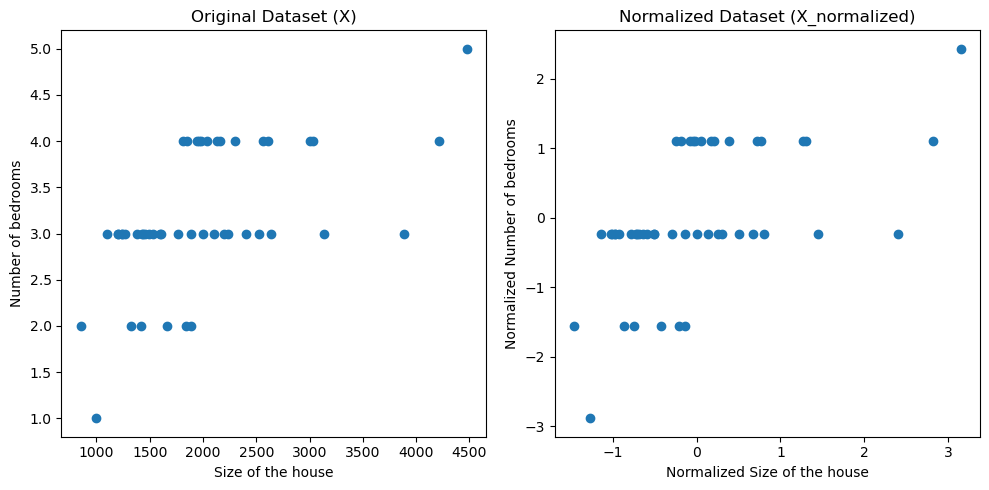

In [4]:
import matplotlib.pylab as plt

""" TODO:
Complete the following code to compute a normalized version of X called: X_normalized
"""
# TODO: compute mu, the mean vector from X
mu = np.mean(X, axis=0)
# TODO: compute std, the standard deviation vector from X
std = np.std(X, axis=0)
# X_normalized = (X - mu) / std
X_normalized = (X - mu) / std



""" TODO:
- Do a scatter plot of the original dataset X """
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Original Dataset (X)')
plt.xlabel('Size of the house')
plt.ylabel('Number of bedrooms')

""" Do a scatter plot of the normalized dataset X_normalized
"""
plt.subplot(1, 2, 2)
plt.scatter(X_normalized[:, 0], X_normalized[:, 1])
plt.title('Normalized Dataset (X_normalized)')
plt.xlabel('Normalized Size of the house')
plt.ylabel('Normalized Number of bedrooms')

plt.tight_layout()
plt.show()

Similar to what you did in Lab2 Part B, you can simplify your implementation of linear regression by adding an additional first column to `X_normalized` with all the values of this column set to $1$. To do this you can re-use the function `add_all_ones_column(..)` defined in Lab2 Part B, which takes a matrix as argument and returns a new matrix with an additional first column (of ones).

In [5]:
""" TODO:
Copy-past here the definition of the function add_all_ones_column(...) that 
you have see in Lab 2 (Part B).
"""
# definition of the function add_all_ones_column() here ...
def add_all_ones_column(X):
    n, d = X.shape # dimension of the matrix X (n lines, d columns)
    XX = np.ones((n, d+1)) # new matrix of all ones with one additional column
    XX[:, 1:] = X # set X starting from column 1 (keep only column 0 unchanged)
    return XX

""" TODO:
Just uncomment the following lines to create a matrix 
X_normalized_new with an additional first column (of ones).
"""
X_normalized_new = add_all_ones_column(X_normalized)

print("Subset of X_normalized_new")
print(X_normalized_new[:10])

Subset of X_normalized_new
[[ 1.          0.13141542 -0.22609337]
 [ 1.         -0.5096407  -0.22609337]
 [ 1.          0.5079087  -0.22609337]
 [ 1.         -0.74367706 -1.5543919 ]
 [ 1.          1.27107075  1.10220517]
 [ 1.         -0.01994505  1.10220517]
 [ 1.         -0.59358852 -0.22609337]
 [ 1.         -0.72968575 -0.22609337]
 [ 1.         -0.78946678 -0.22609337]
 [ 1.         -0.64446599 -0.22609337]]


# 3. Linear Regression from Scrach
You are now ready to implement the linear regression using gradient descent (with more than one feature). In this multivariate case, you can further simply your implementation by writing the cost function in the following vectorized form:

$$E(\theta) = \frac{1}{2n} (X \theta - y)^T (X \theta - y)$$

$$\text{where }\quad
X = \begin{bmatrix}
-- ~ {x^{(1)}}^T ~ -- \\ 
-- ~ {x^{(2)}}^T ~ -- \\ 
\vdots \\ 
-- ~ {x^{(n)}}^T ~ --
\end{bmatrix}
\quad \quad \quad
y = \begin{bmatrix}
y^{(1)} \\ 
y^{(2)} \\ 
\vdots \\ 
y^{(n)} 
\end{bmatrix}
$$

The vectorized form of the gradient of $E(\theta)$ is a vector denoted as $\nabla E(\theta)$ and defined follows:

$$\nabla E(\theta) = \left ( \frac{\partial E}{\partial \theta_0}, \frac{\partial E}{\partial \theta_1}, \dots, \frac{\partial E}{\partial \theta_d} \right ) = \frac{1}{n} X^T (X \theta - y)$$

this is a **vector** where each $j^{th}$ value corresponds to $\frac{\partial E}{\partial \theta_j}$ (the derivative of the function $E$ with respect to the parameter $\theta_j$)

One your code is finished, you will get to try out different learning rates $\alpha$ for the dataset and find a learning rate that converges quickly. To do so, you can plot the history of the cost $E(\theta)$ with respect to the number of iterations at the end of your code.

For example for alpha values of 0.01, 0.05 and 0.1, the plot should look like follows:
<img src="imgs/costLab2C.png" width="400px" />

If your learning rate is too large, $E(\theta)$ can diverge and *blow up*, resulting in values which are too large for computer calculations. In these situations, Python will tend to return `NaN` or `inf` (NaN stands for "*not a number*" and is often caused by undefined operations that involve $-\inf$ and $+\inf$). If your value of $E(\theta)$ increases or even blows up, adjust your learning rate and try again.

alpha = 0.01, theta = [215810.61679138  61446.18781361  20070.13313796]
alpha = 0.05, theta = [ 3.38397236e+05  1.03161481e+05 -3.22620198e+02]
alpha = 0.1, theta = [340403.61773803 108803.37852266  -5933.9413402 ]


/var/folders/m1/5ms9qc214pl6gncxzmtk57040000gn/T/ipykernel_70603/843983180.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


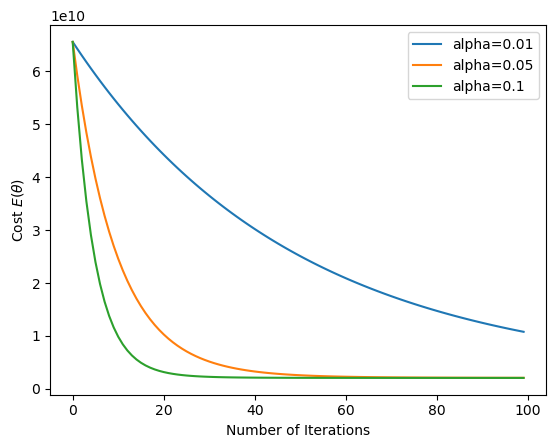

In [8]:

def E(theta, X, y):
    h = X.dot(theta)
    error = h - y
    mse = (1 / (2 * len(y))) * np.sum(error**2)
    return mse

def grad_E(theta, X, y):
    h = X.dot(theta)
    error = h - y
    gradient = (1 / len(y)) * X.T.dot(error)
    return gradient


def LinearRegressionWithGD(theta, alpha, max_iterations, epsilon):
    errs = []
    
    for itr in range(max_iterations):
        mse = E(theta, X_normalized_new, y)
        errs.append(mse)
        
        # take a gradient descent step to adapt the vector of parameters theta
        theta = theta - alpha * grad_E(theta, X_normalized_new, y)
        
        # if the cost decreases by less than epsilon, stop iterating
        if len(errs) > 1 and abs(errs[-1] - errs[-2]) < epsilon:
            break
    
    return errs, theta


""" TODO: 
Here you will call LinearRegressionWithGD(..) in a loop with different values of alpha, 
and plot the cost history (errs) returned by each call of LinearRegressionWithGD(..)
"""
fig, ax = plt.subplots()
ax.set_xlabel("Number of Iterations")
ax.set_ylabel(r"Cost $E(\theta)$")

theta_init = np.array([0, 0, 0])
max_iterations = 100
epsilon = 0.000000000001

for alpha in [0.01, 0.05, 0.1]:
    # TODO: call LinearRegressionWithGD(...) using the current alpha, to get errs and theta
    errs, theta = LinearRegressionWithGD(theta_init, alpha, max_iterations, epsilon)
    
    print("alpha = {}, theta = {}".format(alpha, theta))
    
    # plot the errs using ax.plot(..)
    ax.plot(range(len(errs)), errs, label=f'alpha={alpha}')
    
plt.legend()
fig.show()


Now, once you have found a good $\theta$ using gradient descent, use it to make a price prediction for a new house of 1650-square-foot with 3 bedrooms. **Note**: since the parameter vector $\theta$ was learned using the normalized dataset, you will need to normalize the new data-point corresponding to this new house before predicting its price.

In [9]:

# Cretate a data-point x corresponding to the new house
new_house = np.array([1650, 3])

# Normalize the feature values of x
normalized_new_house = (new_house - mu) / std

normalized_new_house_with_bias = np.insert(normalized_new_house, 0, 1)

# Use the vector of parameters theta to predict the price of x
predicted_price = normalized_new_house_with_bias.dot(theta)

print("Predicted Price for the New House:", predicted_price)



Predicted Price for the New House: 293214.16354571155


'\nHINT: if you are not able to compute the dot product between x and theta, then \nmake sure that the arrays have the same size. Did you forget something?\n'

### 4. (removed). 

# 5. Normal Equation: Linear regression without gradient descent

As you know from the lecture, the MSE cost function $E(\theta)$ that we are trying to minimize is a convex function, and its derivative at the optimal $\theta$ (that minimizes $E(\theta)$) is equal to $0$. Therefore, to find the optimal $\theta$, one can simply compute the derivative of $E(\theta)$ with respect to $\theta$, set it equal to $0$, and solve for $\theta$.

We have seen in the lecture that, by doing this, the closed-form solution is given as follows:
$$\theta = (X^T X)^{-1} X^T y$$

Using this formula does not require any feature scaling, and you will get an exact solution in one calculation: there is no "*loop until convergence*" like in gradient descent.

You are asked to implement this equation to directly compute the best parameter vector $\theta$ for the linear regression. In Python, you can use the `inv` function from `numpy.linalg.inv` to compute the inverse of a function.

Remember that while you don't need to scale your features, we still need to add a column of 1's to the $X$ matrix to have an intercept term ($\theta_0$).

In [10]:
from numpy.linalg import inv

""" TODO: 
Use the function add_all_ones_column(..) to add a column of 1's to X. 
Let's call the returned dataset X_new.
"""
X_new = add_all_ones_column(X)

""" TODO: 
Compute the optimal theta using new_X and y (without using gradient descent).
Use the normal equation shown above. You can use the function inv (imported above)
to compute the inverse of a matrix.
"""
theta = inv(X_new.T.dot(X_new)).dot(X_new.T).dot(y)

print("With the original (non-normalized) dataset: theta = {}".format(theta))

With the original (non-normalized) dataset: theta = [89597.9095428    139.21067402 -8738.01911233]


Now, once you have computed the optimal $\theta$, use it to make a price prediction for the new house of 1650-square-foot with 3 bedrooms. Remeber that $\theta$ was computed above based on the original dataset (without normalization); so, you do not need to normalize the feature values of the new house to make the prediction in this case.

In [11]:
""" TODO: 
Use theta to predict the price of a 1650-square-foot house with 3 bedrooms
"""
new_house = np.array([1, 1650, 3])  # Adding the bias term (1) at the beginning
prediction = new_house.dot(theta)
print(prediction)

293081.46433489455


Using the previous formula does not require any feature normalization or scaling. However, you can still compute again the optimal $\theta$ when using `X_normalized_new` instead of `new_X`.

By doing this, you will be able to compare the $\theta$ that you compute here with the one you got previously when you used gradient descent. The two parameter vectors should be quite similar (but not necessarily exatly the same).

In [12]:
""" TODO: 
Compute the optimal theta using X_normalized_new and y (without using gradient descent). 
Use the normal equation (shown previously).
"""
theta_normalized = inv(X_normalized_new.T.dot(X_normalized_new)).dot(X_normalized_new.T).dot(y)
print("With the normalized dataset: theta = {}".format(theta))

With the normalized dataset: theta = [89597.9095428    139.21067402 -8738.01911233]


Again, now that you have computed the optimal $\theta$ based on `X_normalized_new`, use it to make a price prediction for the new house of 1650-square-foot with 3 bedrooms. Do you need to normalize the feature values of the new house here? Remeber that $\theta$ was computed here based on the normalized dataset.

You should find that this predicted price similar to the price you predicted previsouly for the same house. 

In [13]:
""" TODO: 
Use theta to predict the price of a 1650-square-foot house with 3 bedrooms
"""
# Create a data-point x corresponding to the new house
new_house = np.array([1, 1650, 3])  # Adding the bias term (1) at the beginning
# Normalize the feature values of x
normalized_new_house = (new_house[1:] - mu) / std
normalized_new_house_with_bias = np.insert(normalized_new_house, 0, 1)
# Use the vector of parameters theta to predict the price of x
predicted_price_normalized = normalized_new_house_with_bias.dot(theta_normalized)

print("Predicted Price for the New House (using normalized theta):", predicted_price_normalized)

Predicted Price for the New House (using normalized theta): 293081.4643348962


# 6. Linear Regression with scikit-learn (sklearn)
You will now use the scikit-learn library to do the ordinary linear regression.

First, the code below shows you how to scale you data using scikit-learn. The `preprocessing` module provides a class `StandardScaler` that compute the mean and standard deviation on a training data so as to be able to later reapply the same transformation on the testing data.

In [14]:
from sklearn.preprocessing import StandardScaler

# Fit the StandardScaler to the training data (to compute the mean and std-deviation)
scaler = StandardScaler().fit(X)

# You can now use scaler to transform (scale) the training data or any new test data
X_normalized = scaler.transform(X)

print("Original X:\n", X[:5])
print()
print("X_normalized:\n", X_normalized[:5])

Original X:
 [[2.104e+03 3.000e+00]
 [1.600e+03 3.000e+00]
 [2.400e+03 3.000e+00]
 [1.416e+03 2.000e+00]
 [3.000e+03 4.000e+00]]

X_normalized:
 [[ 0.13141542 -0.22609337]
 [-0.5096407  -0.22609337]
 [ 0.5079087  -0.22609337]
 [-0.74367706 -1.5543919 ]
 [ 1.27107075  1.10220517]]


Complete the following code to train an ordinary linear regression on the scaled training dataset. Then, use the trained model to predict the price of new test houses.

In [16]:
from sklearn.linear_model import LinearRegression

""" TODO:
Train the linear regression model on the scaled training data
"""
reg = LinearRegression().fit(X_normalized, y)


In [17]:
""" TODO: 
Use the trained regression model to predict the price of the following test houses
* 1650-square-foot house with 3 bedrooms
* 1020-square-foot house with 2 bedrooms
* 2300-square-foot house with 4 bedrooms
"""
X_test = X_test = np.array([[1650, 3], [1020, 2], [2300, 4]]) # Create the test dataset

# Scale the test dataset using scaler.transform(...)
X_test_normalized = scaler.transform(X_test)

# Predict the prices using reg.predict(...)
predicted_prices = reg.predict(X_test_normalized)

print("Predicted Prices for the Test Houses:")
for i, predicted_price in enumerate(predicted_prices):
    print(f"Test House {i+1}: ${predicted_price:.2f}")

Predicted Prices for the Test Houses:
Test House 1: $293081.46
Test House 2: $214116.76
Test House 3: $374830.38


The prediction you get for the first test house (`[1650, 3]`) should be similar to the prediction you got for this house when you implemented the linear regression from scrach.

- For more information about data scaling in scikit-learn, check the link: https://scikit-learn.org/stable/modules/preprocessing.html
- For more information about the ordinary linear regression, check the link: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 